In [1]:
# --- Importing necessary libraries ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import ruptures as rpt

In [2]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load the CSV file
file_path = '/Users/linli-shang/Library/CloudStorage/OneDrive-Personal/On_Going/VASSCAA_submission/Paper draft/data copy/Comp_1.pkl'  # Replace with the actual path to your CSV file
oes_data = pd.read_pickle(file_path)

# Separate the wavelength (first column) and intensity values (other columns)
wavelengths = oes_data.iloc[:, 0]  # Assuming first column is wavelength
intensities = oes_data.iloc[:, 1:]  # The remaining columns are intensity values at different time steps

# Normalize the intensity values between 0 and 1
scaler = MinMaxScaler()
normalized_intensities = scaler.fit_transform(intensities)

# Convert the normalized intensities back to a DataFrame for easier processing
normalized_data = pd.DataFrame(normalized_intensities, columns=intensities.columns)

# Print the first few rows of the normalized data
normalized_data.head()

,1,2,3,4,5,6,7,8,9,10,...,2240,2241,2242,2243,2244,2245,2246,2247,2248,2249
0,0.017983,0.023687,0.020947,0.023803,0.025028,0.024247,0.019450,0.025113,0.019336,0.018630,...,0.022005,0.023086,0.017464,0.021877,0.028129,0.033678,0.024031,0.016128,0.022533,0.022139
1,0.017914,0.024027,0.022549,0.019987,0.023850,0.019565,0.018349,0.021765,0.021035,0.018017,...,0.018923,0.021803,0.015264,0.024300,0.027649,0.032418,0.021031,0.013304,0.020104,0.020407
2,0.019641,0.024959,0.021382,0.019374,0.022753,0.017979,0.018877,0.020441,0.021097,0.018543,...,0.019533,0.021080,0.016917,0.025592,0.025304,0.029186,0.019793,0.016145,0.021730,0.019580
3,0.022088,0.026128,0.019108,0.020042,0.021690,0.017631,0.020056,0.019927,0.020504,0.019526,...,0.021567,0.020572,0.020055,0.026447,0.022239,0.025195,0.019235,0.021170,0.024922,0.019103
4,0.024429,0.027279,0.016904,0.020713,0.020742,0.017331,0.021205,0.019453,0.019938,0.020542,...,0.023614,0.020217,0.023101,0.027294,0.019252,0.021441,0.018778,0.025931,0.027961,0.018687


In [3]:
## Data Transformation 


transposed_data = normalized_data.T
transposed_data_np = transposed_data.to_numpy()

In [4]:
# --- VAE Model Definition ---

# Sampling function for VAE
def sampling(z_mean, z_log_var):
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Build VAE Encoder
def build_encoder(input_dim, latent_dim):
    inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(128, activation='relu')(inputs)
    x = layers.Dense(64, activation='relu')(x)
    z_mean = layers.Dense(latent_dim)(x)  # Latent mean
    z_log_var = layers.Dense(latent_dim)(x)  # Latent log variance
    return models.Model(inputs, [z_mean, z_log_var], name='encoder')

# Build VAE Decoder
def build_decoder(latent_dim, output_dim):
    latent_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(64, activation='relu')(latent_inputs)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(output_dim, activation='sigmoid')(x)
    return models.Model(latent_inputs, outputs, name='decoder')

# Define VAE Model
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z_mean, z_log_var = self.encoder(inputs)
        z = sampling(z_mean, z_log_var)
        return self.decoder(z)

In [5]:
# --- Build and Train VAE ---

# Set dimensions for VAE
input_dim = transposed_data_np.shape[1]  # 4550 wavelengths (rows)
latent_dim = 2  # Latent space dimension

# Build encoder and decoder
encoder = build_encoder(input_dim, latent_dim)
decoder = build_decoder(latent_dim, input_dim)

# Create VAE model
vae = VAE(encoder, decoder)

# Compile the VAE
vae.compile(optimizer='adam', loss='mse')


In [6]:
# Train the VAE
vae.fit(transposed_data_np, transposed_data_np, epochs=70, batch_size=32)

# --- Extract Latent Features from VAE Encoder ---

# Use the trained VAE encoder to get the latent space representation
latent_features = vae.encoder(transposed_data_np)[0].numpy()  # The [0] selects the z_mean

# The shape of `latent_features` is (num_time_steps, latent_dim)
print(f"Shape of latent features: {latent_features.shape}")

Epoch 1/70


2024-10-11 15:28:54.664093: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0714
Epoch 2/70
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0031
Epoch 3/70
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.1655e-04
Epoch 4/70
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.4540e-04
Epoch 5/70
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.2381e-04
Epoch 6/70
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.1846e-04
Epoch 7/70
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.1807e-04
Epoch 8/70
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.0984e-04
Epoch 9/70
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.0640e-04
Epoch 10/70
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 9.8259e-05
Epoch 11/70
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 9.7385e-05
Epoch 12/70
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 9.2924e-05
Epoch 13/70
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 9.4033e-05
Epoch 14/70
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.8566e-05
Epoch 15/70
71/71 ━━━━━━━━━━━━━━━━

Shape of latent_features: (2249, 2)
Expanded shape of latent_features: (2249, 1, 2)
Shape of X_train: (2248, 1, 2)
Shape of y_train: (2248,)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 64)          │        17,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,601 (115.63 KB)

 Trainable params: 29,601 (115.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.5903

2024-10-11 15:29:55.581220: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.5880 - val_loss: 0.3142
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0210 - val_loss: 0.1154
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 6.2186e-04 - val_loss: 0.0943
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.8527e-04 - val_loss: 0.0802
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.6002e-04 - val_loss: 0.0700
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 9.9144e-05 - val_loss: 0.0625
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 6.5079e-05 - val_loss: 0.0567
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 4.7324e-05 - val_loss: 0.0519
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 3.5196e-05 - val_loss: 0.0481
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.7695e-05 - val_loss: 0.0448
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 2.2074e-05 - val_loss: 0.0421
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━

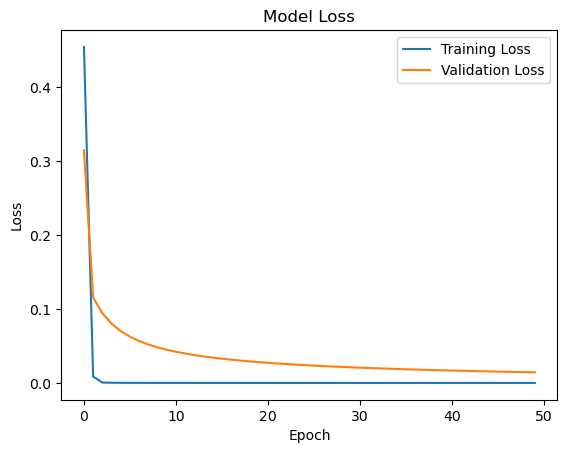

In [7]:
# --- LSTM Model Definition and Training ---

# Assuming latent_features is your input data
print("Shape of latent_features:", latent_features.shape)

# Ensure latent_features is a 3D array (samples, time steps, features)
# No need to add an extra dimension multiple times, just ensure it's (num_samples, time_steps, latent_dim)
if len(latent_features.shape) == 2:
    latent_features = np.expand_dims(latent_features, axis=1)
    print("Expanded shape of latent_features:", latent_features.shape)

# Use latent_features directly for X_train (should be 3D)
X_train = latent_features[:-1]  # Remove the last time step
y_train = np.zeros(len(X_train))  # Create dummy labels (unsupervised)

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)

# Build LSTM model for temporal pattern detection
lstm_model = models.Sequential([
    layers.Input(shape=(X_train.shape[1], X_train.shape[2])),
    layers.LSTM(64, activation='relu', return_sequences=True),
    layers.LSTM(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

lstm_model.summary()

lstm_model.compile(optimizer='adam', loss='binary_crossentropy')

# Train the LSTM model
history = lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Plot training history
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [8]:
# --- Evaluate VAE Reconstruction Error and LSTM Output ---

# Get reconstruction from the VAE
reconstructed_data = vae(transposed_data_np)

# Compute VAE reconstruction error (MSE for each time step)
reconstruction_errors = tf.reduce_mean(tf.square(transposed_data_np - reconstructed_data), axis=1).numpy()

# Get LSTM predictions (anomaly score) - no need to add extra dimension
lstm_predictions = lstm_model.predict(latent_features)

# Combine the VAE reconstruction error and LSTM predictions
combined_signal = reconstruction_errors + lstm_predictions.flatten()


71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [9]:
reconstructed_data

<tf.Tensor: shape=(2249, 4550), dtype=float32, numpy=
array([[0.02217829, 0.02076885, 0.02062309, ..., 0.01335972, 0.01493578,
        0.01564198],
       [0.02150298, 0.02010364, 0.01996404, ..., 0.01287964, 0.01443027,
        0.01509158],
       [0.02179426, 0.02038979, 0.02024702, ..., 0.01308455, 0.01464898,
        0.01532565],
       ...,
       [0.02649837, 0.02475755, 0.02427719, ..., 0.01578112, 0.01761978,
        0.01877477],
       [0.02697634, 0.02520638, 0.02470854, ..., 0.01611479, 0.01796061,
        0.01913709],
       [0.02188012, 0.02037103, 0.0199594 , ..., 0.01265329, 0.01421864,
        0.01520068]], dtype=float32)>

In [10]:
latent_features

array([[[ -3.45196  ,  -7.4376364]],

       [[ -3.3816276,  -7.5634933]],

       [[ -3.3935008,  -7.5168433]],

       ...,

       [[ -9.755225 ,   4.3113675]],

       [[ -9.776435 ,   4.3203588]],

       [[-10.234811 ,   4.5073857]]], dtype=float32)

In [11]:
latent_features.shape

(2249, 1, 2)

In [12]:
import numpy as np
import tensorflow as tf

# Convert TensorFlow tensors to NumPy arrays if necessary and concatenate them
latent_features_full = np.concatenate(
    [tensor.numpy() if isinstance(tensor, tf.Tensor) else tensor for tensor in latent_features],
    axis=0
)

# Check the shape of the final reconstructed data
print("Shape of latent_features_full:", latent_features_full.shape)


Shape of latent_features_full: (2249, 2)


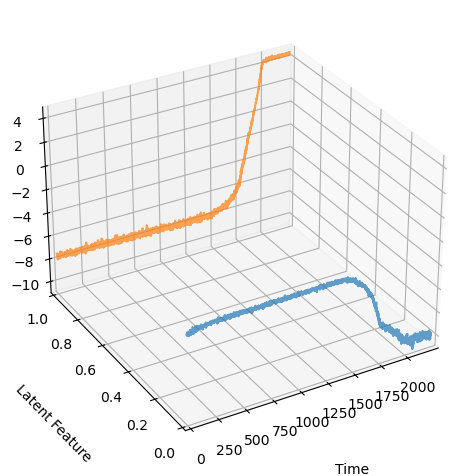

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a larger figure and 3D axis with adjusted margins
fig = plt.figure(figsize=(6, 9))
ax = fig.add_subplot(111, projection='3d')

# Prepare the data for plotting
time = np.arange(latent_features_full.shape[0])
features = np.arange(latent_features_full.shape[1])

# Plot with better separation and slightly transparent lines
for feature in features:
    ax.plot(time, np.full_like(time, feature), latent_features_full[:, feature], alpha=0.7)

# Set labels
ax.set_xlabel('Time', labelpad=20)  # Adding padding to the labels
ax.set_ylabel('Latent Feature', labelpad=20)
ax.set_zlabel('Value', labelpad=20)

# Adjusting the view angle and margins
ax.view_init(elev=30, azim=240)  # Adjust the viewing angle to make axes labels more visible
fig.subplots_adjust(left=0.1, right=0.85, top=0.85, bottom=0.1)  # Adjust the margins

# Set axis limits to better visualize the data
ax.set_xlim([0, latent_features_full.shape[0]])
ax.set_ylim([0, latent_features_full.shape[1] - 1])
ax.set_zlim([latent_features_full.min(), latent_features_full.max()])

# Display the plot
plt.show()

In [78]:
lstm_predictions

array([[3.8023592e-07],
       [3.4161937e-07],
       [4.0741148e-07],
       ...,
       [2.4522930e-01],
       [2.4275447e-01],
       [2.3763779e-01]], dtype=float32)

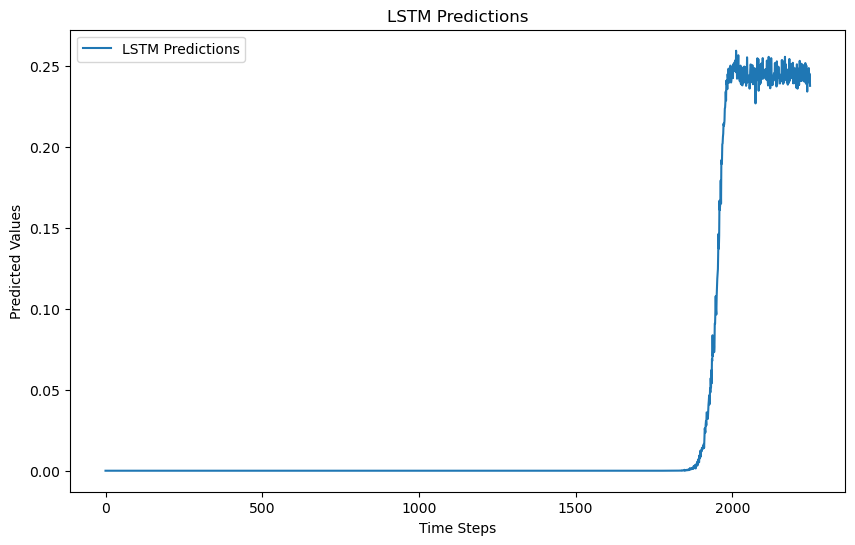

In [79]:
import matplotlib.pyplot as plt

# Assuming lstm_predictions is a numpy array or a similar data structure
plt.figure(figsize=(10, 6))
plt.plot(lstm_predictions, label='LSTM Predictions')
plt.title('LSTM Predictions')
plt.xlabel('Time Steps')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

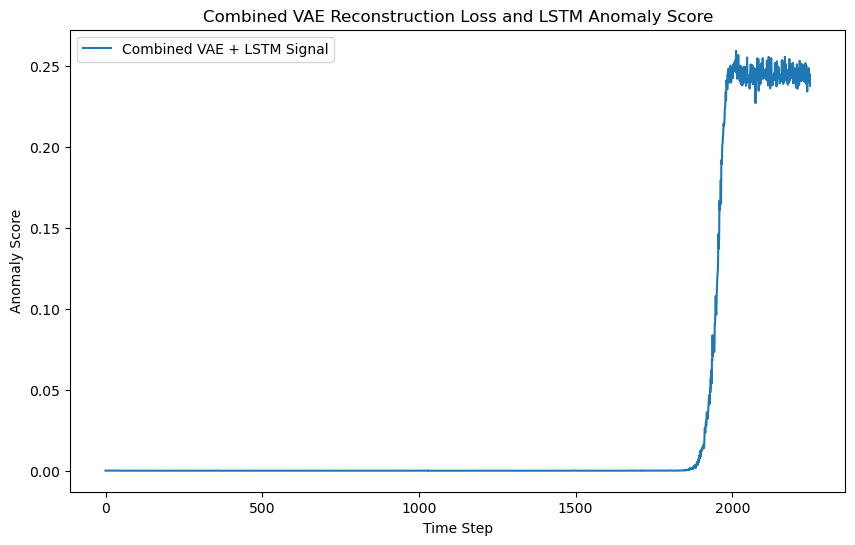

In [80]:
# --- Visualization: Combined Anomaly Signal ---

plt.figure(figsize=(10, 6))
plt.plot(combined_signal, label='Combined VAE + LSTM Signal')
plt.xlabel('Time Step')
plt.ylabel('Anomaly Score')
plt.title('Combined VAE Reconstruction Loss and LSTM Anomaly Score')
plt.legend()
plt.show()

Detected change points: [90, 1525, 1885, 2249]


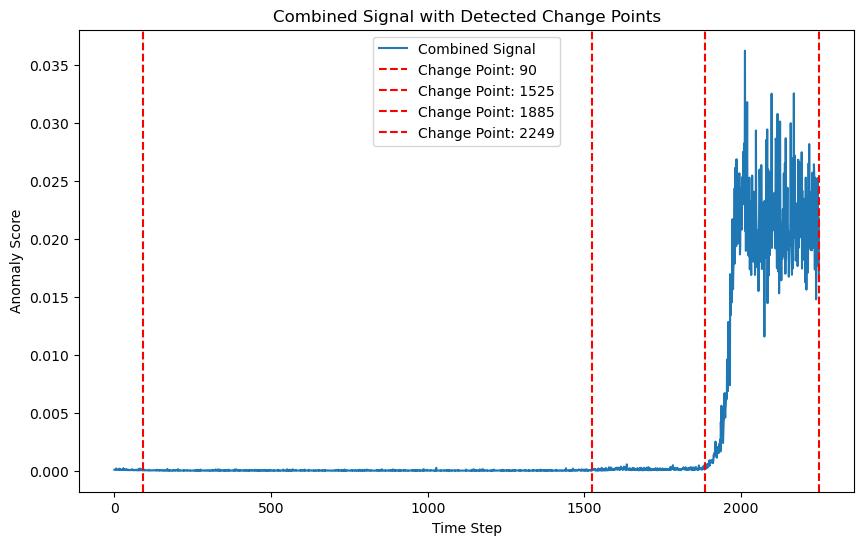

In [22]:
# --- Optional: Change-Point Detection ---

import ruptures as rpt

# Apply change-point detection on the combined signal
algo = rpt.Pelt(model="rbf").fit(combined_signal)
change_points = algo.predict(pen=10)  # Adjust the penalty as needed

# Print and visualize change points
print(f"Detected change points: {change_points}")

plt.figure(figsize=(10, 6))
plt.plot(combined_signal, label='Combined Signal')
for cp in change_points:
    plt.axvline(x=cp, color='r', linestyle='--', label=f'Change Point: {cp}')
plt.xlabel('Time Step')
plt.ylabel('Anomaly Score')
plt.title('Combined Signal with Detected Change Points')
plt.legend()
plt.show()

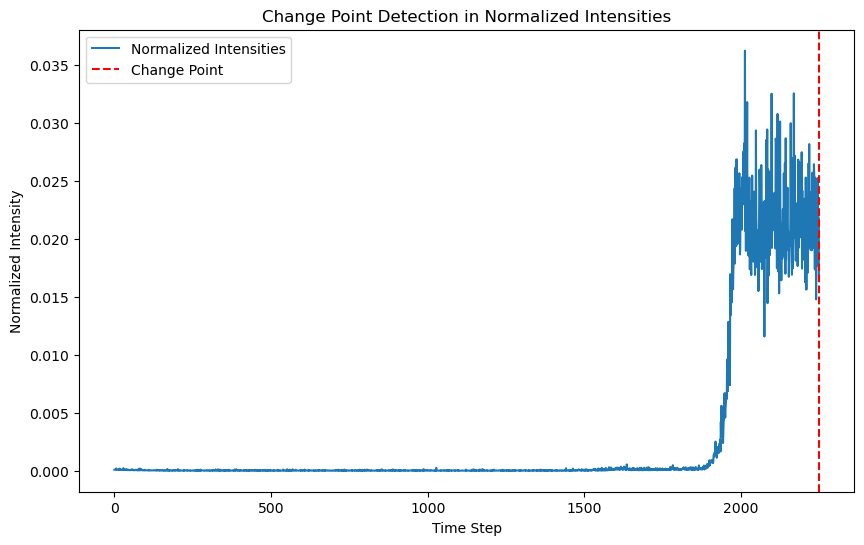

In [21]:
# Import necessary libraries
import ruptures as rpt
import numpy as np
import matplotlib.pyplot as plt

# Assuming `normalized_intensities` is your normalized data (already prepared above)
# Define the method for change point detection
def change_point_detection(intensity_data, model="l1", penalty=10):
    """
    Detect change points in the intensity data using ruptures.

    Parameters:
        intensity_data (ndarray): Normalized intensity data (e.g., time-series data).
        model (str): The cost function model to use (e.g., "l1", "l2", "rbf").
        penalty (float): Penalty value for controlling the sensitivity of the change point detection.

    Returns:
        list: Indices where change points were detected.
    """
    # Initialize the change point detection algorithm
    algo = rpt.Pelt(model=model, min_size=5, jump=1)
    # Fit the algorithm on the intensity data and predict change points
    change_points = algo.fit(intensity_data).predict(pen=penalty)
    
    return change_points

# Apply change point detection to your data
intensity_data = combined_signal.flatten()  # Assuming you need a 1D array for change point detection
change_points = change_point_detection(intensity_data)

# Plotting to visualize change points in the time series
plt.figure(figsize=(10, 6))
plt.plot(intensity_data, label="Normalized Intensities")
for cp in change_points:
    plt.axvline(x=cp, color="red", linestyle="--", label="Change Point")
plt.xlabel("Time Step")
plt.ylabel("Normalized Intensity")
plt.title("Change Point Detection in Normalized Intensities")
plt.legend()
plt.show()

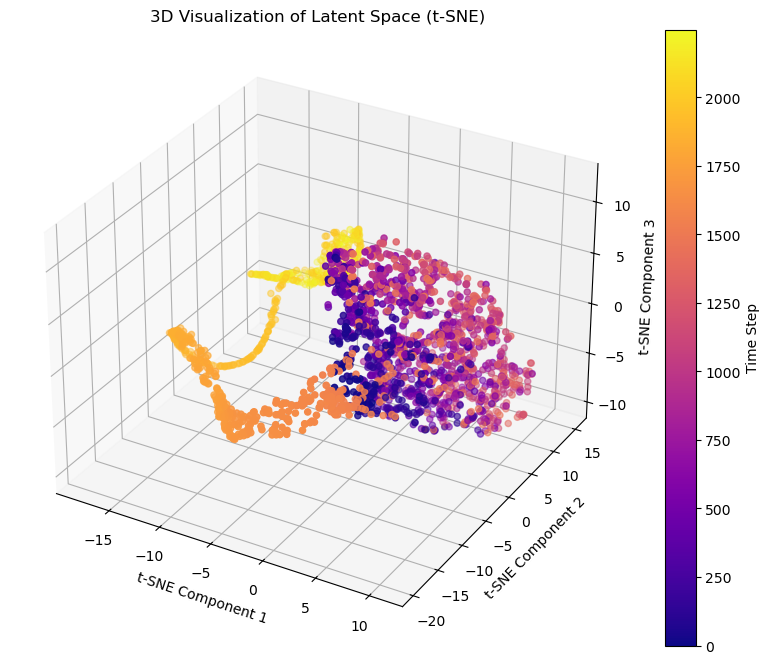

In [56]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Assuming latent_features is a 3D array
# Reshape the 3D array to 2D (combining last two dimensions)
latent_features_reshaped = latent_features.reshape(latent_features.shape[0], -1)

# Perform t-SNE to reduce latent features to 3D
tsne = TSNE(n_components=3, random_state=42)
latent_features_3d = tsne.fit_transform(latent_features_reshaped)

# Plot the latent features in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(latent_features_3d[:, 0], latent_features_3d[:, 1], latent_features_3d[:, 2], 
                c=np.arange(len(latent_features_3d)), cmap='plasma')

# Add labels and title
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')
plt.title('3D Visualization of Latent Space (t-SNE)')

# Add color bar
plt.colorbar(sc, label='Time Step')

# Show the plot
plt.show()